# Touschek Effect in FCC-ee

In [4]:
# import general libs (probably not required)
#
import matplotlib as mpl
import matplotlib.pyplot as plt 
from numpy import log, log10, log2, sqrt, pi, arccos, arange
import pandas as pd
from os.path import expanduser
from IPython.core.display import display, HTML
from scipy.constants import k, hbar, alpha, pi, speed_of_light, elementary_charge, m_e, physical_constants, N_A
print( " --- constants: \n", k, hbar, alpha, pi, speed_of_light)
# change to source dir to import specific stuff
#
%cd ~/Python/FCCee-Synchrotron-Radiation/source/
import VisualSpecs
from TfsTables import TfsReader, PlotOptics 
from DF_Tools import OutputToDF
from Input import checkRing
from Tools import sbplSetUp


# temporarily disable the SetCopies warning:
# pd.options.mode.chained_assignment = None

# %reload_ext autoreload

# %aimport TfsTables, Input, OpticsSelectTools, Plot, PlotSetup

# %autoreload 1
%matplotlib inline

home = expanduser("~")
plotpath = "/tmp/"

display(HTML("<style>.container { width:100% !important; }</style>"))

# declare the constants (also machine)
#
r_e = physical_constants['classical electron radius'][0]
# beam energy [GeV]
E0 = 182.5
if E0 == 45.6:
    Nbun = 16640; Np = 1.7e11
    sigZ = 3.5e-3
    epsX = .27e-9; epsY = 1e-12
elif E0 == 182.5:
    Nbun = 48; Np = 2.3e11
    sigZ = 1.97e-3
    epsX = 1.46e-9; epsY = 2.9e-12
Lrnt = E0/511e-6
brho = 10*E0/2.9979
particle = "positron"

print("---- Beam Parameters b1 ---- \n", " Beam energy =", E0, 'with', Nbun, 'bunches/beam with population of', Np, 'particles \n', 'bunch length (SR) =', sigZ, "m",
      "\n emittance x,y =", epsX, epsY, "m",
      "\n Brho =", brho, "\n Lorentz gamma =", Lrnt, 
     "\n ----------------------------- " )

b1 = TfsReader( home + '/Codes/Projects/FCC-ee-lattice/MadX/output/' + str(E0) + '/fcc_ee_b1_twiss.tfs' ).read_twiss( verbose = 0, relS = 1) 

 --- constants: 
 1.38064852e-23 1.0545718001391127e-34 0.0072973525664 3.141592653589793 299792458.0
/home/nikita/Python/FCCee-Synchrotron-Radiation/source


---- Beam Parameters b1 ---- 
  Beam energy = 182.5 with 48 bunches/beam with population of 230000000000.0 particles 
 bunch length (SR) = 0.00197 m 
 emittance x,y = 1.46e-09 2.9e-12 m 
 Brho = 608.7594649588045 
 Lorentz gamma = 357142.85714285716 
 ----------------------------- 
 Add column 'rel_S' -- S position shifted with IP in the center. Using Lmax =  97756.06428319066


## Introduction: Da$\Phi$ne

### Basic Theory
B-factory with LER (4 GeV), HER (7 GeV) setup. 
Touschek lifetime estimate based on the loss rate as below:
$$ \begin{equation} \frac{1}{N}\frac{dN}{dt} = \frac{1}{\tau} = \frac{Nr_0^2c}{8\pi\sigma_x\sigma_y\sigma_s}\frac{\lambda^3}{\gamma^2}D(\xi). \end{equation} $$
$\lambda$ is the momentum acceptance, $\sigma_i$ comprises beam sizes (all three dimensions), further we have the Lorentz factor $\gamma$ and $$ \xi = \left( \frac{\Delta E/E}{\gamma} \right)^2\frac{\beta_x}{\epsilon_x}$$
$D(\xi)$ has been approximated with $$ \sqrt{\xi}\left( \ln\left( \frac{1}{1.78\xi} \right) - \frac{3}{2} \right)$$ for $\xi$ < 0.01.
For the HER, machine parameters are listed as
* $E_0$ = 7 GeV
* $\sigma_S$ = 6 mm
* $\Delta E/E$ = 0.1 %
* $\epsilon_x$ = 1.6 nm
* $\epsilon_y$ = 4 pm
* $\beta_x$ = 10 m
* $\beta_y$ = 22 m

Where the values for $\beta_{x,y}$ are an average. As for the RF system on the HER, with a total RF voltage of 15 MV, and energy loss/turn of 3.3 MeV the voltage factor would be $$ \begin{align} q &= \frac{eV_{RF}}{U_0} = \frac{15}{3.3}. \end{align} $$

Baseline functions are implemented below, as defined above. 

In [12]:
# loss rate as defined above
#
def TshkRate(N, sigmX, sigmY, sigmS, lam, xi):
    return N*r_e**2*speed_of_light/(8*pi*sigmX*sigmY*sigmS)*lam**3/Lorentz**2*D(xi)

# factor xi as above
#
def xi(betX, epsX):
    return (deltE/Lorentz)**2*betX/epsX

# approximation for D(xi)
#
def D(dE):
    xi = (dE/Lorentz)**2*betx/epsX
    return sqrt(xi)*(log(1/(1.78*xi)) - 3/2)
    

def F(q):
    return 2*( sqrt(q**2 - 1) - arccos(1/q) )

def lamRF(V0, E0, q):
    return sqrt(V0/(pi*eta*h*E0)*F(q))


### Machine Acceptance and RF parameters
The total machine acceptance in $\Delta p/p$ is the lesser one out of RF ($\lambda_{RF}$) and lattice acceptance, where $$ \lambda_{RF} = \sqrt{ \frac{V_0}{\pi|\eta|hE_0}F(q) }.$$
$q$ is the voltage factor $eV_{RF}/V_0$, basically describing maximum energy gain in the cavity over RF voltage. The function F(q) is displayed below for a certain range in q.

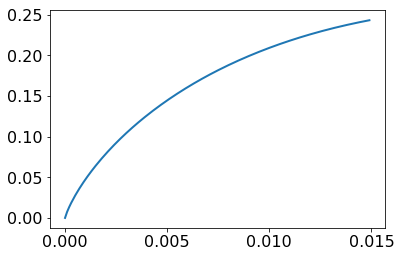

In [21]:
# xiRange = arange(10e-4, 10e-3, 1e-4)
dERange = arange(1e-35,1.5e-2,1e-4)
plt.plot( dERange, D(dERange))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arccos


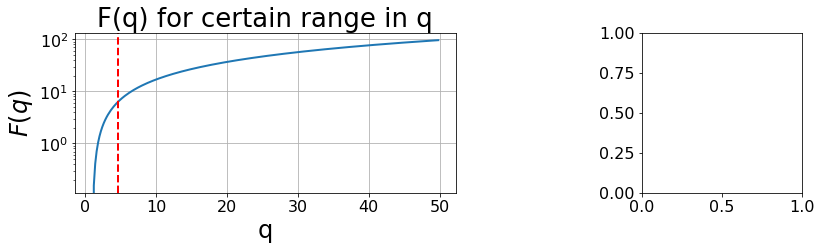

In [11]:
xrange = arange(1e-18, 50, .2)
axs = sbplSetUp(2)
axs[0].plot( xrange, F(xrange))
axs[0].set_yscale('log'); axs[0].set_xlabel('q'); axs[0].set_ylabel('$F(q)$')

axs[0].axvline( x = 15/3.3, ls = '--', color = 'red')
axs[0].grid(); axs[0].set_title('F(q) for certain range in q');

### Evaluation for the HER
First, design parameters are implemented and derived quantities calculated (as necessary/possible). 

In [14]:
# for daphne (HER, nom): 
#
E0 = 7 # [GeV]
deltE = 0.1
Lorentz = E0/511e-6
betx = 10; bety = 22 # avrg, [m]
epsX = 1.6e-9 # [m]
epsY = 4e-12 # [m]
h = 3570
fRF = 476e6 # [MHz]
V0 = 15e6 # [V]
dp = 9e-4
alphP = 3e-4
N = 3.52e10
nB = 1733
sigmX = sqrt(epsX*betx); sigmY = sqrt(epsY*bety); sigmS = 6e-3
XI = xi(betx, epsX)
eta = alphP - 1/Lorentz**2
print( ' ---- DAPHNE PARAMETER SET ---- \n', 'E0 = ', E0, '\n gamma =', Lorentz, '\n eta =', eta, '\n gam_trns =', sqrt(1/alphP), '\n sigma_x =', sigmX, '\n sigma_y =', sigmY, '\n xi =', XI, 
       '\n D(xi) =', D(XI))

 ---- DAPHNE PARAMETER SET ---- 
 E0 =  7 
 gamma = 13698.630136986303 
 eta = 0.00029999467099999996 
 gam_trns = 57.735026918962575 
 sigma_x = 0.00012649110640673518 
 sigma_y = 9.38083151964686e-06 
 xi = 0.33306249999999993 
 D(xi) = -6.50363019735192


#### Plot the Loss rate as fct. of $\Delta E/E$ 
Shall help to check consistency of the underlying loss rate implementation.

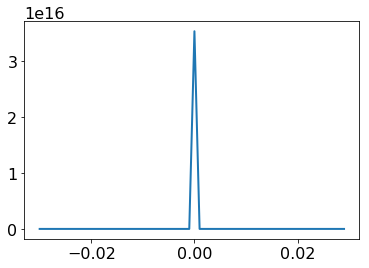

In [76]:
# try to write loss rate as fct. of energy deviation
#
def TshkRateNew(accpt, dE):
    return N*r_e**2*speed_of_light/(8*pi*sigmX*sigmY*sigmS)*1/accpt**3*1/Lorentz**2*D(dE)
Erange = arange(-0.03,0.03, 0.001)
plt.plot(Erange, 1/TshkRateNew(0.01, Erange))

## FCC-ee
As implemented in `MDISim`, the Touschek lifetime can be estimated using 

In [5]:
avgBetx = b1.BETX.mean(); sigmX = sqrt(avgBetx*epsX)
avgBety = b1.BETY.mean(); sigmY = sqrt(avgBety*epsY)
print(avgBetx, avgBety, '\n', sigmX, sigmY)

59.880877463391386 100.06628420032716 
 0.0002956790170041686 1.7035029327269995e-05
